In [103]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk import FreqDist
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment import sentiment_analyzer, vader, SentimentAnalyzer, SentimentIntensityAnalyzer
from xgboost import XGBClassifier
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline

### Getting data from Ask Men Subreddit ###

In [2]:
url_submissions = 'https://api.pushshift.io/reddit/search/submission'
url_comments = 'https://api.pushshift.io/reddit/search/comment'

In [5]:
AM_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'removed_by_category', 'retrieved_on', 'score', 'selftext',
       'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'title',
       'total_awards_received', 'treatment_tags', 'upvote_ratio', 'url',
       'whitelist_status', 'wls', 'post_hint', 'preview',
       'author_flair_background_color', 'author_flair_text_color',
       'banned_by']

In [104]:
AM_posts_df = pd.DataFrame()#columns = AM_posts_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_submissions, params = {'subreddit': 'AskMen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AM_posts_df = pd.concat([AM_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

502
502


In [108]:
AM_posts_df.shape

(1800, 65)

In [115]:
AM_posts_df['title_selftext'] = AM_posts_df['title']+AM_posts_df['selftext']
AM_posts_df[['title_selftext', 'title', 'selftext']].head()

,title_selftext,title,selftext
0,Would you live in an area with high police pre...,Would you live in an area with high police pre...,[removed]
1,What are some slang terms a 34-year old dad co...,What are some slang terms a 34-year old dad co...,[removed]
2,Ask permission?[removed],Ask permission?,[removed]
3,"How long is “normal” sex?Well, I know there is...",How long is “normal” sex?,"Well, I know there is no such thing as normal ..."
4,My mom have anger management problem[removed],My mom have anger management problem,[removed]


In [11]:
AM_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'distinguished']

In [105]:
AM_comments_df = pd.DataFrame(columns = AM_comments_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_comments, params = {'subreddit': 'AskMen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AM_comments_df = pd.concat([AM_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

502
502


In [111]:
AM_comments_df.shape

(1800, 37)

### Getting data from AskWomen Subreddit ###

In [15]:
resp = requests.get(url_submissions, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
pd.DataFrame(resp.json()['data']).columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type',
       'suggested_sort', 'thumbnail', 't

In [17]:
AW_posts_cols = ['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type',
       'suggested_sort', 'thumbnail', 'title', 'total_awards_received',
       'treatment_tags', 'upvote_ratio', 'url', 'whitelist_status', 'wls',
       'author_flair_template_id', 'author_flair_text_color']

In [106]:
AW_posts_df = pd.DataFrame(columns = AW_posts_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_submissions, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AW_posts_df = pd.concat([AW_posts_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

In [110]:
AW_posts_df.shape

(2000, 67)

In [116]:
AW_posts_df['title_selftext'] = AW_posts_df['title']+AW_posts_df['selftext']
AW_posts_df[['title_selftext', 'title', 'selftext']].head()

,title_selftext,title,selftext
0,What to do when I said something I shouldn't[r...,What to do when I said something I shouldn't,[removed]
1,What's a creepy encounter you've had a with a ...,What's a creepy encounter you've had a with a ...,[removed]
2,Would a girl get bothered if she sees the guy ...,Would a girl get bothered if she sees the guy ...,[removed]
3,What are my chances of being pregnant?[removed],What are my chances of being pregnant?,[removed]
4,what does discharging of breast milk mean for ...,what does discharging of breast milk mean for ...,[removed]


In [22]:
AW_comments_cols = ['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'distinguished', 'gildings', 'id', 'is_submitter',
       'link_id', 'locked', 'no_follow', 'parent_id', 'permalink',
       'retrieved_on', 'score', 'send_replies', 'stickied', 'subreddit',
       'subreddit_id', 'top_awarded_type', 'total_awards_received',
       'treatment_tags']

In [107]:
AW_comments_df = pd.DataFrame(columns = AW_comments_cols)
before_params = [1609187173] # first timestamp is equivalent to now 
for i in range(1, 21):
    resp = requests.get(url_comments, params = {'subreddit': 'AskWomen','size': 100,'before': before_params[-1]})
    try: 
        batch = pd.DataFrame(resp.json()['data'])
        AW_comments_df = pd.concat([AW_comments_df, batch], axis = 0 )
        before_params.append(batch['created_utc'].min())
        time.sleep(2)
    except:
        print(resp.status_code)

502
502
502


In [109]:
AW_comments_df.shape

(1700, 37)

In [25]:
AW_comments_df['body']

0     Non-sexual affection, a good film, fine dining...
1     Probably right now.  \n\nMy son is 11, he is i...
2     I'd also like to know. Cause in some countries...
3     I actually kind of agree with this. My situati...
4     Better education and easier access to birth co...
                            ...                        
95    I love my life now. I'm 43. The extensive care...
96    Sometimes its lonely. Im okay, feel like I mig...
97    Putting lemon slices on top of and *under* sal...
98    That’s an amazing story!! It’s lines like that...
99    First introduced to them in HomeEc class in hi...
Name: body, Length: 800, dtype: object

### DATA EXPORTS

In [117]:
AW_comments_df.to_csv('aw_com.csv')
AW_posts_df.to_csv('aw_pos.csv')
AM_comments_df.to_csv('am_com.csv')
AM_posts_df.to_csv('am_pos.csv')

### Dealing with stop words

In [113]:
stops = stopwords.words('english')
additions = ["!","?",".",":",";", ",", "\'", "\"","*", "'", '"', "[", ']', '(', ")", '’', '[removed]']
stops.extend(additions)

_More to be done here later_

### Creating corpora

In [118]:
AW_comments_corpus = ''
for i in range(len(AW_comments_df)):
    AW_comments_corpus+=(AW_comments_df.iloc[i,list(AW_comments_df.columns).index('body')])

AM_comments_corpus = ''
for i in range(len(AM_comments_df)):
    AM_comments_corpus+=(AM_comments_df.iloc[i,list(AM_comments_df.columns).index('body')])

AW_posts_corpus = ''
for i in range(len(AW_posts_df)):
    AW_posts_corpus+=str(AW_posts_df.iloc[i,list(AW_posts_df.columns).index('title_selftext')])
    
AM_posts_corpus = ''
for i in range(len(AM_posts_df)):
    AM_posts_corpus+=str(AM_posts_df.iloc[i,list(AM_posts_df.columns).index('title_selftext')])

### Sentiment analysis

In [119]:
sia = SentimentIntensityAnalyzer()

In [120]:
sia.polarity_scores(AW_comments_corpus)

{'neg': 0.068, 'neu': 0.806, 'pos': 0.125, 'compound': 1.0}

In [121]:
sia.polarity_scores(AM_comments_corpus)

{'neg': 0.093, 'neu': 0.77, 'pos': 0.137, 'compound': 1.0}

_How about for each comment separately?_

### Count Vectorizer and dumb model on just comments (SKIPPED)

In [ ]:
X = pd.concat([BOS_comments_df['body'], LA_comments_df['body']], axis = 0)

In [ ]:
X = pd.concat([BOS_comments_df['body'], LA_comments_df['body']], axis = 0)

In [ ]:
X.shape

In [ ]:
y = np.concatenate([np.zeros_like(BOS_comments_df['body']), np.ones_like(LA_comments_df['body'])]).astype(int)

In [ ]:
type(y)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [ ]:
cvec = CountVectorizer(stop_words='english', lowercase = True, max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [ ]:
train_y.mean()

In [ ]:
test_y.mean()

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

In [ ]:
mnb.score(test_X_vec, test_y)

### FUN WITH SPACY (SKIPPED)

In [ ]:
import spacy
from spacy import displacy
en_mdl = spacy.load('en_core_web_md')
nlp = spacy.load('en_core_web_sm')

In [ ]:
displacy.render(nlp(str('I miss Boston sometimes')), jupyter=True, style='ent')

In [ ]:
doc = nlp(BOS_comments_corpus + BOS_posts_corpus)
bos_loc_gpe = []
for ent in doc.ents:
    if ent.label_ in ['LOC', 'GPE']:
        bos_loc_gpe.append(ent.text)

BOS_locations = list(set(bos_loc_gpe))
BOS_locations.append('Harvard') # adding some which were not detected by Spacy NER

In [ ]:
poppers =  ['Airbnb', 'Aquarium', 'Atlanta', 'Austin', 'Australia', 'Automobiles',           
            'Billy','Black', 'Brno', 
           'California', 'Canada','Carolinas','Central','Charlotte', 'Chicago','Chlamydia', 'Comcast','Czech Republic',
           'DC','Davis','Dec 21.Found', 'Detroit', 'Downtown', 'Dubai',
           'East', 'England',
           'Florida','Hong Kong','Hotel','Houston','Hyde Park',
           'Jan', 'Japan', 'Kansas', 'Kansas City', 'Karaoke',
           'Meridian', 'Miami', 'Midwest','Minecraft!Just','Mississippi','Mueller','Mumbai',
            'NH','NY','Naples','Nashville',
           'States', 'Storrow', 'Suffolk County', 'Sweden','Syracuse', 'Syria', 
           'Tennessee','Texas',"The Combat Zoneit's",'Toronto',
            'U.K.','US','USA','Venmo', 'Vermont', 'Washington', 'Washington DC']
for popper in poppers:
    BOS_locations.remove(popper) #removing some which are not BOS specific

In [ ]:
#BOS_locations.sort()
#BOS_locations

In [ ]:
doc = nlp(LA_comments_corpus + LA_posts_corpus)
la_loc_gpe = []
for ent in doc.ents:
    if ent.label_ in ['LOC', 'GPE']:
        la_loc_gpe.append(ent.text)

LA_locations = list(set(la_loc_gpe))
LA_locations.append("Westside")

In [ ]:
#LA_locations.sort()
#LA_locations

In [ ]:
la_poppers = ['East','Japan', 'Midwest', 'Mueller', 'Texas', 'US', 'USA', 'Vermont', 'Washington', 'Washington DC', 'the United States','Vancouver', 'Vegas', 'Bernie', 'America', 'Chicago', 'boston', 'Colorado', 'Tokyo','Tsunamis', 'U.S.','United State','United States Of America']
for popper in la_poppers:
    LA_locations.remove(popper) #removing some which are not LA specific

In [ ]:
LA_comments_df['body_np'] = LA_comments_df['body'] 
for loc in LA_locations:
    LA_comments_df['body_np'] = LA_comments_df['body_np'].apply(lambda x: x.replace(loc, "PLACE"))

In [ ]:
BOS_comments_df['body_np'] = BOS_comments_df['body']
for loc in BOS_locations:
    BOS_comments_df['body_np'] = BOS_comments_df['body_np'].apply(lambda x: x.replace(loc, "PLACE"))

### WHAT ABOUT WITHOUT LOCATION NAMES? (SKIPPED)

In [ ]:
X = pd.concat([BOS_comments_df['body_np'], LA_comments_df['body_np']], axis = 0)

In [ ]:
X.shape

In [ ]:
y = np.concatenate([np.zeros_like(BOS_comments_df['body_np']), np.ones_like(LA_comments_df['body_np'])]).astype(int)

In [ ]:
type(y)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [ ]:
cvec = CountVectorizer(stop_words='english', lowercase = True, max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [ ]:
train_y.mean()

In [ ]:
test_y.mean()

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

### NOW ON ACTUAL POSTS (SKIPPED)

In [ ]:
LA_posts_df['title_selftext_np'] = LA_posts_df['title_selftext']
for loc in LA_locations:
    LA_posts_df['title_selftext_np'] = LA_posts_df['title_selftext_np'].apply(lambda x: str(x).replace(loc, "PLACE"))

In [ ]:
BOS_posts_df['title_selftext_np'] = BOS_posts_df['title_selftext']
for loc in BOS_locations:
    BOS_posts_df['title_selftext_np'] = BOS_posts_df['title_selftext_np'].apply(lambda x: x.replace(loc, "PLACE"))

In [ ]:
X = pd.concat([BOS_posts_df['title_selftext_np'].dropna(), LA_posts_df['title_selftext_np'].dropna()], axis = 0)

In [ ]:
X.shape

In [ ]:
np.ones_like(LA_posts_df['title_selftext_np'].dropna()).sum()

In [ ]:
X.dropna(inplace = True)

In [ ]:
y = np.concatenate([np.zeros_like(BOS_posts_df['title_selftext_np'].dropna()), np.ones_like(LA_posts_df['title_selftext_np'].dropna())]).astype(int)

In [ ]:
y.shape

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [ ]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,2))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [ ]:
train_y.mean()

In [ ]:
test_y.mean()

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

In [ ]:
mnb.score(test_X_vec, test_y)

### NOW ON POSTS and COMMENTS

In [122]:
X = pd.concat([AW_posts_df['title_selftext'].dropna(), AW_comments_df['body'].dropna(), AM_posts_df['title_selftext'].dropna(), AM_comments_df['body'].dropna()], axis = 0)

In [123]:
X.shape

(7262,)

In [124]:
X.dropna(inplace = True)

In [125]:
y = np.concatenate([np.zeros_like(AW_posts_df['title_selftext'].dropna()),
                    np.zeros_like(AW_comments_df['body'].dropna()),
                    np.ones_like(AM_posts_df['title_selftext'].dropna()),
                    np.ones_like(AM_comments_df['body'].dropna())]).astype(int)

In [126]:
y.shape

(7262,)

In [127]:
train_X, test_X, train_y, test_y = train_test_split(X,y)

In [128]:
cvec = CountVectorizer(stop_words='english', lowercase = True, ngram_range=(1,2))#max_features=10_000)
train_X_vec = cvec.fit_transform(train_X)
test_X_vec = cvec.transform(test_X)

In [129]:
train_y.mean()

0.49136981270657365

In [130]:
test_y.mean()

0.4895374449339207

In [131]:
mnb = MultinomialNB()

In [132]:
mnb.fit(train_X_vec, train_y)
mnb.score(train_X_vec, train_y)

0.9507895703268454

In [133]:
mnb.score(test_X_vec, test_y)

0.6872246696035242

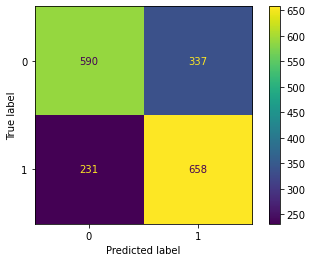

In [134]:
plot_confusion_matrix(mnb, test_X_vec, test_y);

In [135]:
X.iloc[[i for i in range(len(mnb.predict(test_X_vec))) if mnb.predict(test_X_vec[i]) == 1 and test_y[i] ==0]]

2     Would a girl get bothered if she sees the guy ...
5     What is your opinion on a partner wearing used...
6     I (guy) have varicocele, weird looking veins a...
21    Why do you think the mid-20s (so the 24-26) ag...
22    When do you wear sexy bodies (the lingerie). D...
                            ...                        
68       Dating a guy who was a virgin till 30[removed]
70    Women of Reddit, have you ever been in a toxic...
73    For those of you who have dated in the US and ...
99    How should I approach prostate play with my BF...
13    What are your feelings in regards to a signifi...
Length: 337, dtype: object

In [137]:
X_vec = cvec.transform(X)

params = {'alpha': np.linspace(0,1,10)}
mnb_gs = GridSearchCV(mnb, params, n_jobs = 5, verbose = 1, cv = 5)

mnb_gs.fit(X_vec, y)
print(f"Best CV score of {round(mnb_gs.best_score_,4)} achieved with alpha = {round(mnb_gs.best_params_['alpha'],4)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Best CV score of 0.6314 achieved with alpha = 1.0


[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    1.7s finished


### MESSING WITH SENTIMENT

In [138]:
sia.polarity_scores(AW_posts_corpus+AW_comments_corpus)

{'neg': 0.067, 'neu': 0.824, 'pos': 0.109, 'compound': 1.0}

In [139]:
sia.polarity_scores(AM_posts_corpus+AM_comments_corpus)

{'neg': 0.081, 'neu': 0.788, 'pos': 0.131, 'compound': 1.0}

In [68]:
AW_posts_df['sia_neg'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_posts_df['sia_pos'] = AW_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_posts_df['sia_neg'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_posts_df['sia_pos'] = AM_posts_df['title_selftext'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

AW_comments_df['sia_neg'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AW_comments_df['sia_pos'] = AW_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])
AM_comments_df['sia_neg'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['neg'])
AM_comments_df['sia_pos'] = AM_comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['pos'])

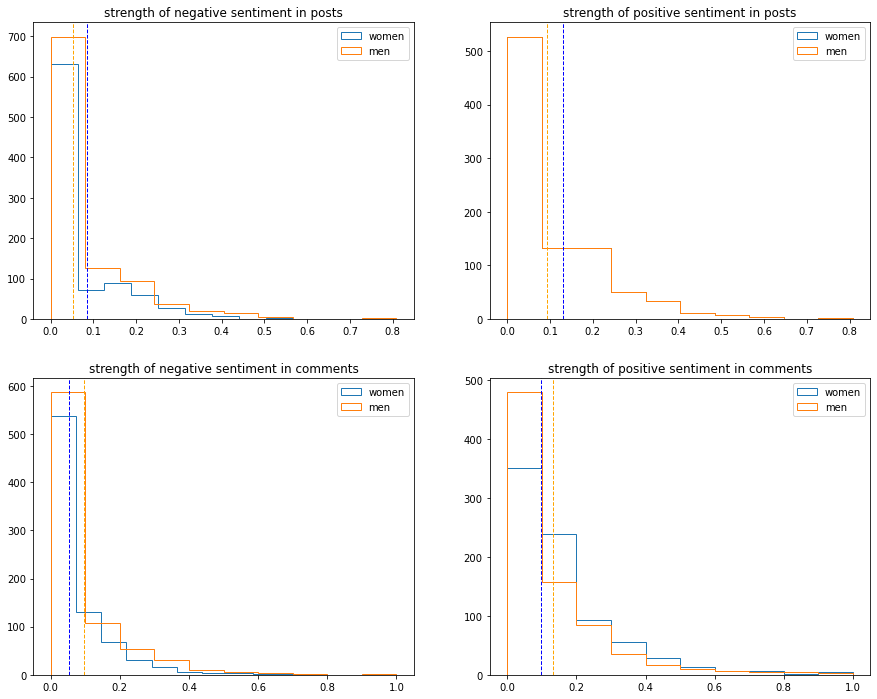

In [69]:
plt.figure(figsize = (15,12))
plt.subplot(2,2,1)
plt.title('strength of negative sentiment in posts')
plt.hist(AW_posts_df['sia_neg'], histtype = 'step', label = 'women')
plt.hist(AM_posts_df['sia_neg'], histtype = 'step', label = 'men')
plt.axvline(sia.polarity_scores(AW_posts_corpus)['neg'], ls = '--', lw = 1, color = 'blue')
plt.axvline(sia.polarity_scores(AM_posts_corpus)['neg'], ls = '--', lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,2)
plt.title('strength of positive sentiment in posts')
plt.hist(AW_posts_df['sia_pos'], histtype = 'step', label = 'women')
plt.hist(AW_posts_df['sia_pos'], histtype = 'step',label = 'men')
plt.axvline(sia.polarity_scores(AW_posts_corpus)['pos'], ls = '--', lw = 1,  color = 'blue')
plt.axvline(sia.polarity_scores(AM_posts_corpus)['pos'], ls = '--',lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,3)
plt.title('strength of negative sentiment in comments')
plt.hist(AW_comments_df['sia_neg'], histtype = 'step', label = 'women')
plt.hist(AM_comments_df['sia_neg'], histtype = 'step', label = 'men')
plt.axvline(sia.polarity_scores(AW_comments_corpus)['neg'], ls = '--', lw = 1, color = 'blue')
plt.axvline(sia.polarity_scores(AM_comments_corpus)['neg'], ls = '--', lw = 1, color = 'orange')
plt.legend();
plt.subplot(2,2,4)
plt.title('strength of positive sentiment in comments')
plt.hist(AW_comments_df['sia_pos'], histtype = 'step', label = 'women')
plt.hist(AM_comments_df['sia_pos'], histtype = 'step',label = 'men')
plt.axvline(sia.polarity_scores(AW_comments_corpus)['pos'], ls = '--', lw = 1,  color = 'blue')
plt.axvline(sia.polarity_scores(AM_comments_corpus)['pos'], ls = '--',lw = 1, color = 'orange')
plt.legend();

In [ ]:
senti = pipeline('sentiment-analysis')

In [74]:
AW_posts_df['senti_pn'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x))[0]['label'] if len(str(x))< 512 else 'n/a')
AW_posts_df['senti_score'] = AW_posts_df['title_selftext'].apply(lambda x: senti(str(x))[0]['score'] if len(str(x)) < 512 else 'n/a')

In [ ]:
AM_posts_df['senti_pn'] = AM_posts_df['title_selftext'].apply(lambda x: senti(x)[0]['label'] if len(str(x)) < 512 else 'n/a')
AM_posts_df['senti_score'] = AM_posts_df['title_selftext'].apply(lambda x: senti(x)[0]['score'] if len(str(x)) < 512 else 'n/a')

In [ ]:
AW_comments_df['senti_pn'] = AW_comments_df['body'].apply(lambda x: senti(x)[0]['label'] if len(str(x)) < 512 else 'n/a')
AW_comments_df['senti_score'] = AW_comments_df['body'].apply(lambda x: senti(x)[0]['score'] if len(str(x)) < 512 else 'n/a')

In [ ]:
AM_comments_df['senti_pn'] = AM_comments_df['body'].apply(lambda x: senti(x)[0]['label'] if len(str(x)) < 512 else 'n/a')
AM_comments_df['senti_score'] = AM_comments_df['body'].apply(lambda x: senti(x)[0]['score'] if len(str(x)) < 512 else 'n/a')

In [77]:
len(AW_posts_df[AW_posts_df['senti_pn'] == 'POSITIVE'])

100

In [78]:
len(AW_posts_df[AW_posts_df['senti_pn'] == 'NEGATIVE'])

790

In [ ]:
len(AM_posts_df[AM_posts_df['senti_pn'] == 'POSITIVE'])

In [97]:
AW_tokens = word_tokenize(AW_posts_corpus+AW_comments_corpus)
AW_tokens_no_stops = [token for token in AW_tokens if not token in stops]

FreqDist(AW_tokens_no_stops)

FreqDist({'I': 1736, 'removed': 715, 'like': 253, 'What': 246, "'s": 242, "n't": 230, 'How': 185, 'would': 177, 'If': 169, 'think': 162, ...})

In [98]:
AM_tokens = word_tokenize(AM_posts_corpus+AM_comments_corpus)
AM_tokens_no_stops = [token for token in AM_tokens if not token in stops]

FreqDist(AM_tokens_no_stops)

FreqDist({'I': 1728, 'removed': 619, 'like': 307, "'s": 276, "n't": 265, 'What': 250, "''": 248, '``': 229, '”': 177, 'How': 175, ...})

### OTHER MODELS

**K-Nearest Neighbors**

In [140]:
knn = KNeighborsClassifier()
knn.fit(train_X_vec, train_y)
knn.score(train_X_vec, train_y)

0.6970253396988616

In [141]:
knn.score(test_X_vec, test_y)

0.5468061674008811

In [142]:
X_vec = cvec.transform(X)

In [143]:
for k in range(1,11):
    knn = KNeighborsClassifier(k)
    print(f"k = {k} --> score = {round(cross_val_score(knn, X_vec, y).mean(),4)}")

k = 1 --> score = 0.5572
k = 2 --> score = 0.5461
k = 3 --> score = 0.5551
k = 4 --> score = 0.5376
k = 5 --> score = 0.5311
k = 6 --> score = 0.5361
k = 7 --> score = 0.5344
k = 8 --> score = 0.5387
k = 9 --> score = 0.5309
k = 10 --> score = 0.5343


**Random Forest Classifier**

In [144]:
rfc = RandomForestClassifier()
rfc.fit(train_X_vec, train_y)
rfc.score(train_X_vec, train_y)

0.987146529562982

In [145]:
rfc.score(test_X_vec, test_y)

0.704295154185022

In [146]:
params = {'bootstrap': [True],
 'ccp_alpha': np.linspace(0,1,5),
 'criterion': ['gini'],
 'max_depth': [2,5,10,15],
 'min_samples_leaf': [1,2,3,4,5],
 'n_estimators': [25,50,75,100,125]}

rfc_gs = GridSearchCV(rfc, params, cv = 5, n_jobs = 5, verbose = 1)

rfc_gs.fit(X_vec, y)
rfc_gs.best_score_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   32.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 16.9min
[Parallel(n_jobs=5)]: Done 2500 out of 2500 | elapsed: 17.5min finished


0.6290347319784846

**Logistic Regression**

In [147]:
logreg = LogisticRegression()
logreg.fit(train_X_vec, train_y)
logreg.score(train_X_vec, train_y)

0.9799853103195005

In [148]:
logreg.score(test_X_vec, test_y)

0.7147577092511013

**XGBC**

In [149]:
xgbc = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')
xgbc.fit(train_X_vec, train_y)
xgbc.score(train_X_vec, train_y)

0.7871832537642306

In [150]:
xgbc.score(test_X_vec, test_y)

0.670704845814978